<a href="https://colab.research.google.com/github/pavankumar1909/AI-ML-Demo-project/blob/main/Trash_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import libraries**

In [ ]:
# Check if TensorFlow is available
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


In [ ]:
import numpy as np                                             #for manipulating the numerical data
import zipfile                                                 #to handle a zipFile
import matplotlib.pyplot as plt                                # For ploting graphs from extracted data
import os                                                      #handles system os
import tensorflow as tf                                        #for ML and DeepLearning
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers


import warnings                                                #To handle warnings occur in a program
import pandas as pd                                            #handling Data Structure, Data manoipulation and data analysis
import tensorflow.keras.utils as utils                         #Data loading and preprocessing etc....
from   tensorflow.keras.models import Sequential               #To run a model in Sequential Layer methods
from   tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, ZeroPadding2D  #For CNN in image classification tasks
from   tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau  #reduces overfitting and stops model improvemnt
from   tensorflow.keras.utils import plot_model                 #visual representation of Keras model's architecture
from   tensorflow.keras.callbacks import ModelCheckpoint        #For resuming training and Saving the Best model
from   pathlib import Path                                       #for handling file paths
from   sklearn.utils.class_weight import compute_class_weight   #address class imbalance in dataset during model training.

In [ ]:
warnings.filterwarnings("ignore")

**Reading the data/files**

In [ ]:
# Update the path if the file is located elsewhere
file_path = "/content/Trash_Classification.zip"  # Replace with the correct path

try:
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall("trash_images")
    print(f"File '{file_path}' extracted successfully!")
except FileNotFoundError:
    print(f"Error: File '{file_path}' not found. Please check the path and ensure the file exists.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

File '/content/Trash_Classification.zip' extracted successfully!


In [ ]:
# Path to the data folder
data_path = "/content/trash_images/Trash_Classification"

print(os.listdir(data_path))

['paper', 'glass', 'metal', 'cardboard', 'plastic']


In [ ]:
main_folder_path = Path(data_path)

all_folders = [d for d in main_folder_path.glob('**/') if d.is_dir()]

# Count number of files in each class
data = []
for folder in all_folders:
    folder_name = folder.name
    file_count = len(list(folder.glob('*.*')))
    if folder_name != data_path:
        data.append({'Folder Name': folder_name, 'File Count': file_count})

count = pd.DataFrame(data)

count = count.set_index('Folder Name')
count

,File Count
Folder Name,
Trash_Classification,0
paper,154
glass,150
metal,147
cardboard,50
plastic,143


In [ ]:
print(f'Total {count.sum()}')

Total File Count    644
dtype: int64


In [ ]:
# Show five image of each class
def plot_imgs(item_dir, top=10):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:5]

    plt.figure(figsize=(10, 10))

    for idx, img_path in enumerate(item_files):
        plt.subplot(5, 5, idx+1)

        img = plt.imread(img_path)
        plt.tight_layout()
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(os.path.basename(item_dir))

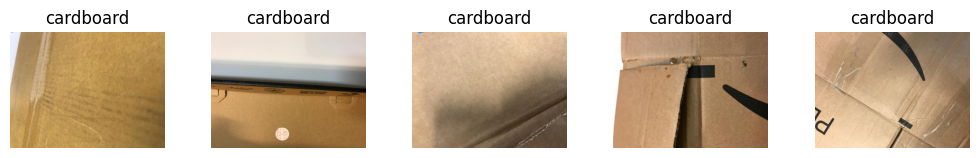

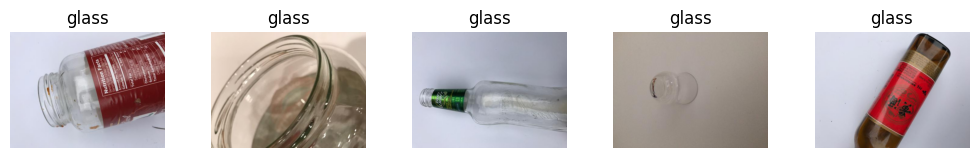

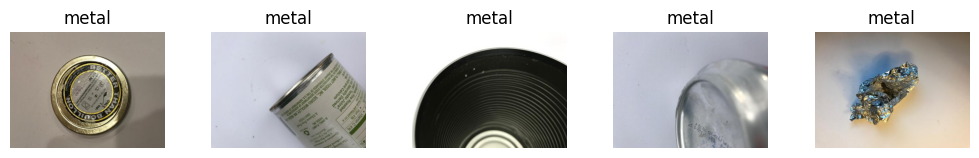

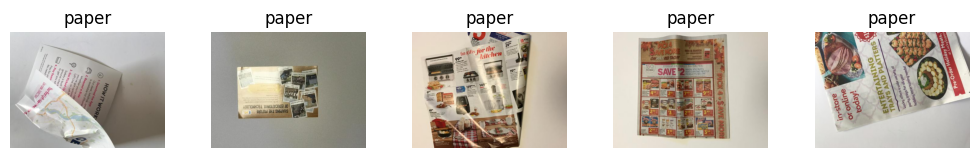

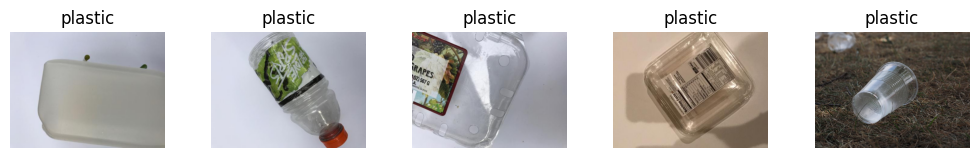

In [ ]:
plot_imgs(data_path+'/cardboard')
plot_imgs(data_path+'/glass')
plot_imgs(data_path+'/metal')
plot_imgs(data_path+'/paper')
plot_imgs(data_path+'/plastic')

**Data Generation and Training**

In [ ]:
# Define variable for requirements
batch_size = 30
target_size = (180, 180)
validation_split = 0.15

In [ ]:
# Data Generators
train_img_generator = ImageDataGenerator(rescale=1./255,
                                         validation_split=validation_split,
                                         horizontal_flip=True,
                                         vertical_flip=True,
                                         zoom_range = 0.5,
                                         width_shift_range = 0.3,
                                         height_shift_range = 0.3,
                                         rotation_range=50,
                                         shear_range = 0.3,
                                         fill_mode='nearest'
                                        )

test_data_img_generator = ImageDataGenerator(rescale=1./255,
                                             validation_split=validation_split
                                            )

**Split Train & Test Files**

In [ ]:
# Separate train Data
train_data = train_img_generator.flow_from_directory(data_path,
                                                        subset="training",
                                                        seed=133,
                                                        target_size=target_size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        color_mode='rgb',
                                                       )

Found 549 images belonging to 5 classes.


In [ ]:
# Separate validation Data
test_data = test_data_img_generator.flow_from_directory(data_path,
                                                        subset="validation",
                                                        seed=133,
                                                        target_size=target_size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        color_mode='rgb',
                                                       )

Found 95 images belonging to 5 classes.


**Model Network Architecture**

In [ ]:
model = Sequential()
model.add(ZeroPadding2D(padding=(1, 1), input_shape=(target_size[0], target_size[1], 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Dropout(0.3))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Dropout(0.3))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Dropout(0.4))
model.add(MaxPool2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

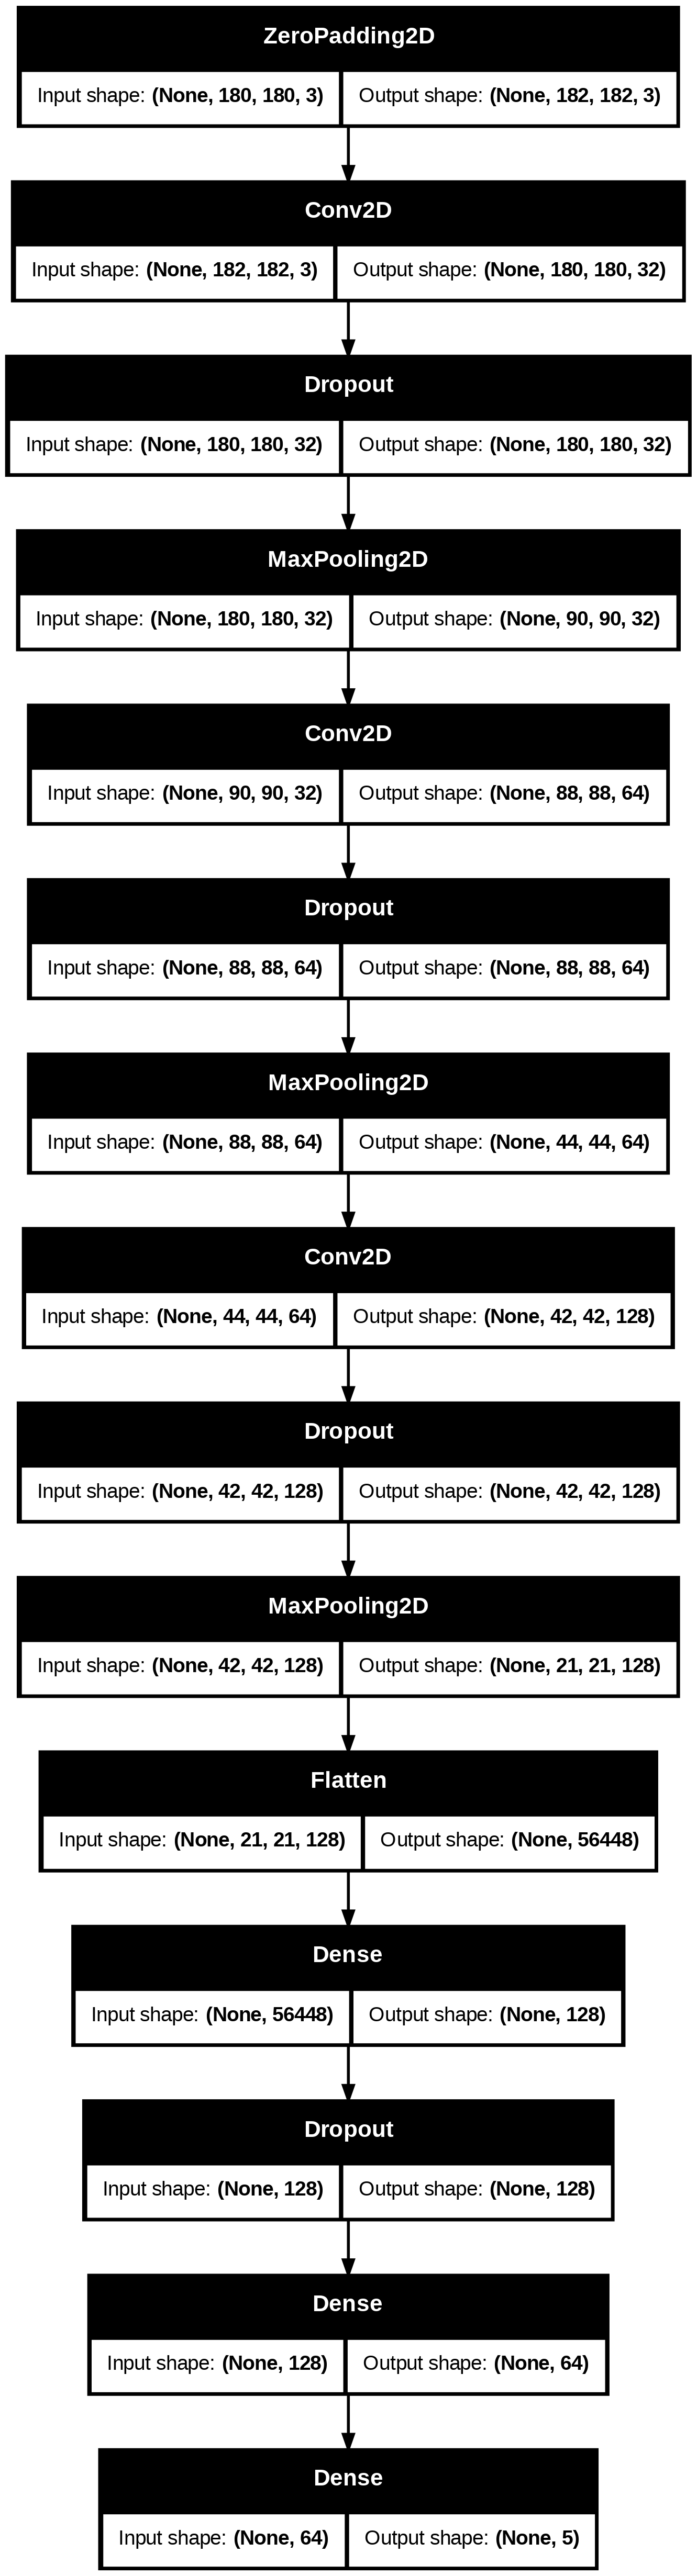

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=False)

**Compiler**

In [ ]:
ES = EarlyStopping(monitor='val_loss', mode='min', patience=10)

In [ ]:
RLROP = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.1, min_lr=0.01)

In [ ]:
MCH = ModelCheckpoint('trash.h5', monitor='val_loss', mode='min', save_best_only=True)

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()]
             )

**Train Model**

In [ ]:
history = model.fit(train_data,
                    steps_per_epoch=len(train_data),
                    epochs=500,
                    validation_data=test_data,
                    validation_steps=len(test_data),
                    callbacks=[ES, RLROP, MCH]
                   )

Epoch 1/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 68s 4s/step - categorical_accuracy: 0.5687 - loss: 1.0637 - val_categorical_accuracy: 0.3789 - val_loss: 1.5637 - learning_rate: 0.0010
Epoch 2/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - categorical_accuracy: 0.4894 - loss: 1.1505 - val_categorical_accuracy: 0.3368 - val_loss: 1.5536 - learning_rate: 0.0010
Epoch 3/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - categorical_accuracy: 0.5193 - loss: 1.1489 - val_categorical_accuracy: 0.4000 - val_loss: 1.5186 - learning_rate: 0.0010
Epoch 4/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - categorical_accuracy: 0.5598 - loss: 1.1092 - val_categorical_accuracy: 0.4000 - val_loss: 1.6267 - learning_rate: 0.0010
Epoch 5/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - categorical_accuracy: 0.5802 - loss: 1.0954 - val_categorical_accuracy: 0.3684 - val_loss: 1.8482 - learning_rate: 0.0010
Epoch 6/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - categorical_accuracy: 0.5015 - loss: 1.1775 - val_categorical_accuracy: 

**Model Evaluation**

In [ ]:
best_score = max(history.history['val_categorical_accuracy'] )
print(f"Best Validation score is: {best_score}")

Best Validation score is: 0.42105263471603394


In [1]:
# Accuracy on train data :
accuracy = history.history['categorical_accuracy']
print("accuracy: "+accuracy)

# Accuracy on test data :
val_accuracy = history.history['val_categorical_accuracy']
epochs = range(1, len(accuracy) + 1)  # Epochs

# Accuracy line plot :
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy, 'b', label='train accuracy')
plt.plot(epochs, val_accuracy, 'r', label='test accuracy')
plt.title('Accuracy plot')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend();

NameError: name 'history' is not defined

In [ ]:
classes = train_data.class_indices
classes

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4}

**Using Trained Model for Predeiction**

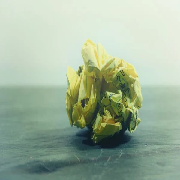

In [ ]:
img = utils.load_img(
    '/content/Pasted image.png',
    color_mode='rgb',
    target_size=(180, 180),
    interpolation='nearest',
    keep_aspect_ratio=False
)

img

In [ ]:
img = utils.img_to_array(img)
img = img / 255.0    # Normalize the image

result = model.predict(tf.expand_dims(img, axis=0))

classes = train_data.class_indices

for key, value in classes.items():
    if value == np.argmax(result):
        print(key)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
paper
